# Logistic Regression

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

torch.manual_seed(42)
plt.style.use('fivethirtyeight')

## 1. Data Input

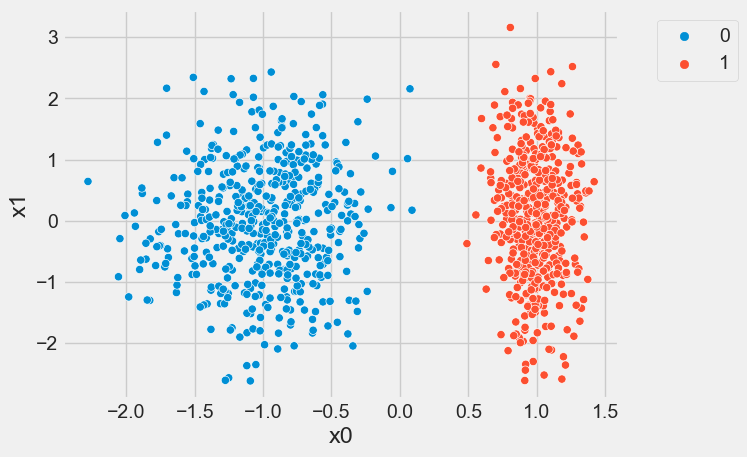

In [2]:
separable = False
dataset = pd.DataFrame()
X, y = None, None
while not separable:
    X, y = make_classification(
        n_samples=1000, # 1000 observations
        n_features=2, # 2 total features
        n_informative=1, # 1 'useful' features
        n_clusters_per_class=1,
        flip_y=-1, # adds noise by flipping a few labels
        n_redundant=0,
    )
    red = X[y == 0]
    blue = X[y == 1]
    separable = any([red[:, k].max() < blue[:, k].min() or red[:, k].min() > blue[:, k].max() for k in range(2)])

    dataset = pd.DataFrame(X)
    dataset.columns = [f'x{i}' for i in range(2)]
    dataset['y'] = y

g = sns.scatterplot(data=dataset, x='x0', y='x1', hue='y')
g.legend(bbox_to_anchor=(1.05, 1))

In [3]:
class MyDataset(Dataset):
    def __init__(self, features_input, label_input):
        self.features = torch.tensor(features_input, dtype=torch.float32)
        self.labels = torch.tensor(label_input, dtype=torch.float32)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return self.labels.shape[0]


X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.3, random_state=42)
train_ds = MyDataset(X_train, y_train)
test_ds = MyDataset(X_test, y_test)

batch_size = 10
train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=True)

## 2. Pytorch Model

<img src='media/logistic_regression.png'>

`Sigmoid Activation` transforms our linear regression output to a probability from 0 to 1. We can then take any probability greater than 0.5 as being 1 and below as being 0.

<img src='media/logistic_regresstion_sigmoid.png'>

In [4]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, num_features):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [5]:
model = LogisticRegression(num_features=2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
num_epochs = 10
iter_ = 0

for epoch in range(num_epochs):
    loop = tqdm(train_loader)
    loop.set_description(f'Epoch {epoch}/{num_epochs}')

    for features, class_labels in loop:
        optimizer.zero_grad()
        output = model(features)
        loss = F.binary_cross_entropy(output, class_labels.view(output.shape))
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            correct, total = 0, 0
            for features, class_labels in test_loader:
                output = model(features)
                pred = torch.where(output > 0.5, 1, 0).squeeze(1)
                total += class_labels.size(0)
                correct += (pred == class_labels).sum().item()
                accuracy = correct / total
            loop.set_postfix(loss=loss.item(), acc=accuracy)

Epoch 9/10: 100%|██████████| 70/70 [00:00<00:00, 115.44it/s, acc=1, loss=0.0482]


(-3.11554225482731, 3.6568825577684496)

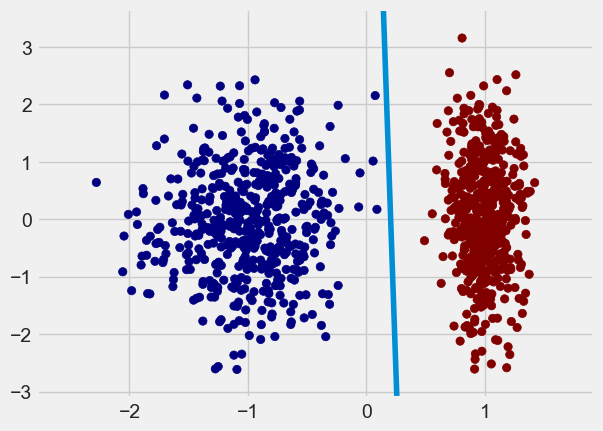

In [6]:
parm = {name: param.detach().numpy() for name, param in model.named_parameters()}
w = parm['linear.weight'][0]
b = parm['linear.bias'][0]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='jet')
u = np.linspace(X[:, 0].min(), X[:, 0].max(), 2)
plt.plot(u, (0.5 - b - w[0]*u) / w[1])

plt.xlim(X[:, 0].min()-0.5, X[:, 0].max()+0.5)
plt.ylim(X[:, 1].min()-0.5, X[:, 1].max()+0.5)